# Importing Libraries and Looking at the Data

In [15]:
from fastai import *
from fastai.imports import *
from fastai.vision import *
from fastai.vision.all import *
import os
from os import listdir
%reload_ext autoreload
%autoreload 2
%matplotlib inline
path = "PlantVillage_tomatoes_augumented"
os.listdir(path)

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

In [5]:
path = Path(path); path

Path('PlantVillage_tomatoes_augumented')

In [11]:
# Define the root directory where the images are located
directory_root = 'PlantVillage_tomatoes_augmented'

# Initialize empty lists to store image paths and labels
image_list, label_list = [], []

try:
    # Print loading message
    print("[INFO] Loading images ...")

    # Get the list of directories in the root directory
    root_dir = listdir(directory_root)

    # Loop through each directory in the root directory
    for disease_folder in root_dir:
        # Print processing message for each disease folder
        print(f"[INFO] Processing {disease_folder} ...")
        
        # Get the list of images in the current disease folder
        plant_disease_image_list = listdir(f"{directory_root}/{disease_folder}/")

        # Add the first 200 images from the disease folder to the image list
        for image in plant_disease_image_list[:200]:
            # Construct the image directory path
            image_directory = f"{directory_root}/{disease_folder}/{image}"
            # Check if the image is a JPEG file and add its path to the image list
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                # Add the label (disease folder name) to the label list
                label_list.append(disease_folder)

    # Print completion message
    print("[INFO] Image loading completed")

# Catch any exceptions that occur during execution
except Exception as e:
    # Print the error message
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


# Training the Model - ResNet

![](https://neurohive.io/wp-content/uploads/2019/01/resnet-architecture-3.png)

In [29]:
# Define your DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define blocks for images and categories
    get_items=get_image_files,  # Function to get image files
    splitter=RandomSplitter(),  # Define how to split data into train and validation sets
    get_y=parent_label,  # Function to get category labels
    batch_tfms=[*aug_transforms()]  # Apply augmentation transforms to batches
)

# Create DataLoaders from DataBlock
dls = dblock.dataloaders(Path(directory_root), bs=64)  # Load data with batch size 64

# Define your CNN architecture using cnn_learner
learn = cnn_learner(dls, resnet34, metrics=accuracy)  # Use ResNet34 architecture with accuracy metric

Train for 5 epochs. Fastai randomly selects training and validation sets.

In [30]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.698666,0.411519,0.866314,15:35
1,0.271219,0.181891,0.938299,08:09
2,0.154871,0.103534,0.961670,08:23
3,0.115233,0.076055,0.972577,08:25
4,0.114861,0.073911,0.972577,08:24


The most confident but wrong predictions

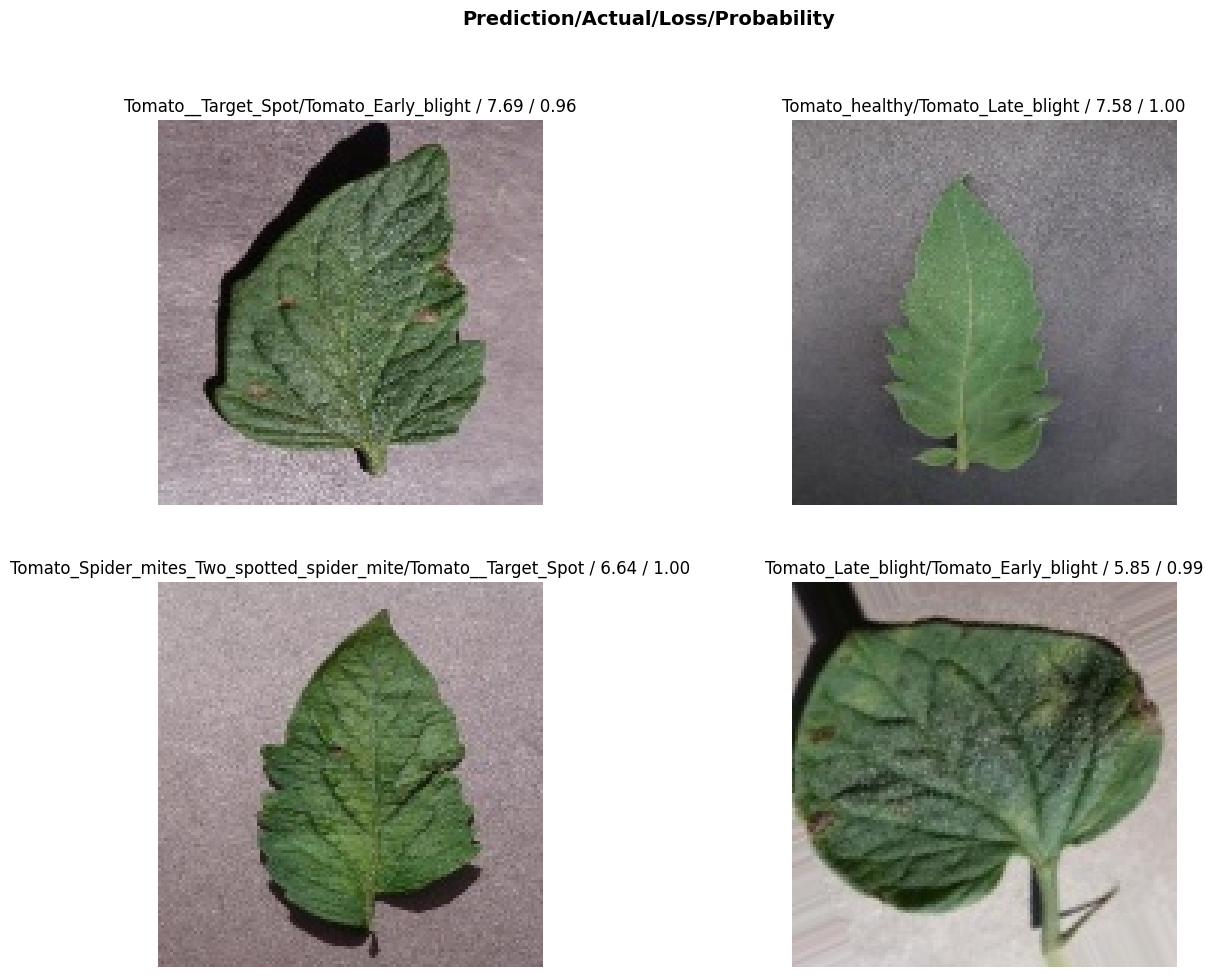

In [31]:
# Create an interpretation object for classification
interpretation = ClassificationInterpretation.from_learner(learn)

# Get the top losses and their corresponding indices
losses, indices = interpretation.top_losses()

# Plot the top losses with their predicted and actual labels
interpretation.plot_top_losses(4, figsize=(15,11))

Plot confusion matrix

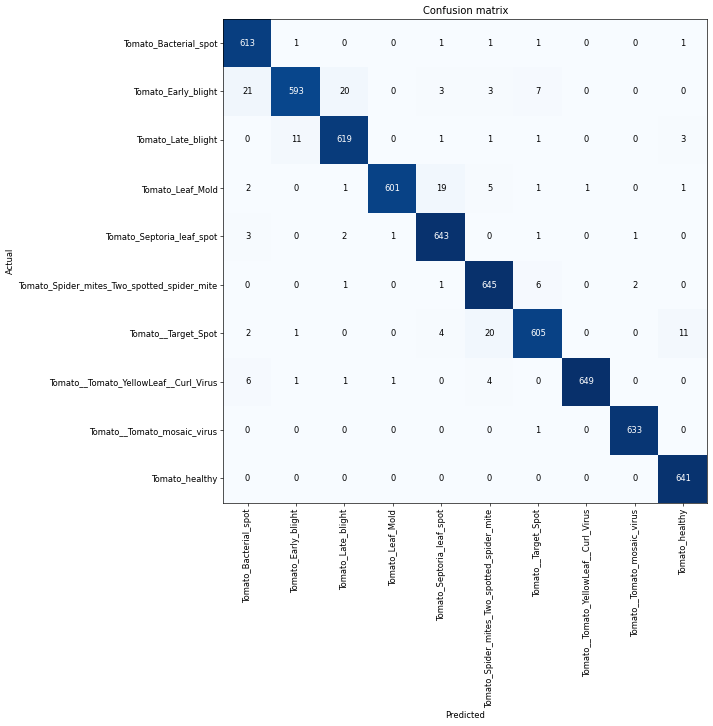

In [32]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

Look at the labels that the model is most confused with.

In [33]:
interpretation.most_confused(min_val=2)

[('Tomato_Early_blight', 'Tomato_Bacterial_spot', 21),
 ('Tomato_Early_blight', 'Tomato_Late_blight', 20),
 ('Tomato__Target_Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 20),
 ('Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 19),
 ('Tomato_Late_blight', 'Tomato_Early_blight', 11),
 ('Tomato__Target_Spot', 'Tomato_healthy', 11),
 ('Tomato_Early_blight', 'Tomato__Target_Spot', 7),
 ('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 6),
 ('Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 6),
 ('Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 5),
 ('Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 4),
 ('Tomato__Tomato_YellowLeaf__Curl_Virus',
  'Tomato_Spider_mites_Two_spotted_spider_mite',
  4),
 ('Tomato_Early_blight', 'Tomato_Septoria_leaf_spot', 3),
 ('Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 3),
 ('Tomato_Late_blight', 'Tomato_healthy', 3),
 ('Tomato_Septoria_leaf_spot', 'Tomato_Bacterial_sp

# Fine Tuning

In [34]:
learn.save('classification-1')

Path('models/classification-1.pth')

In [35]:
# Unfreeze all layers of the model
learn.unfreeze()

# Train the model for one epoch with the 1cycle policy
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.112448,0.068893,0.975538,04:45


As soon as we let the model un-learn, its error rate becomes significantly higher. So, one should find an optimum learning rate at which the model should learn.

SuggestedLRs(valley=4.365158383734524e-05)

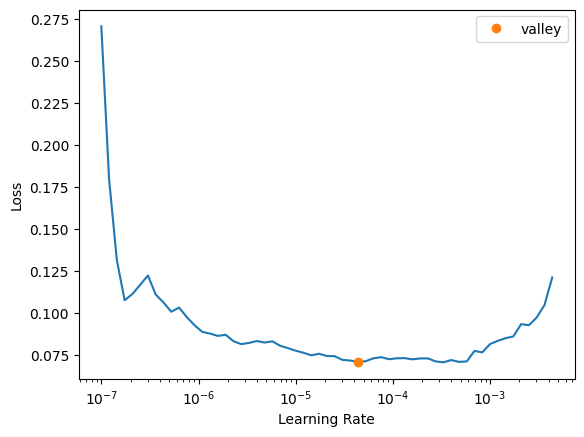

In [36]:
# Find optimal learning rate using lr_find method
learn.lr_find()

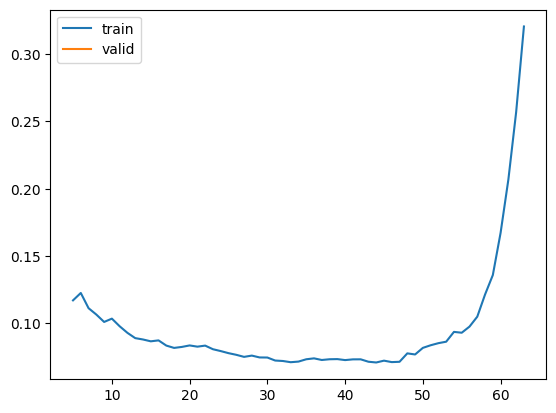

In [38]:
learn.recorder.plot_loss()

In [40]:
# Unfreeze the model's layers
learn.unfreeze()

# Train the model using the fit_one_cycle method
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.076134,0.064797,0.978342,04:57
1,0.063042,0.038167,0.987691,04:58
2,0.033513,0.038135,0.988470,04:55


Look again at the confidently wrong predictions.

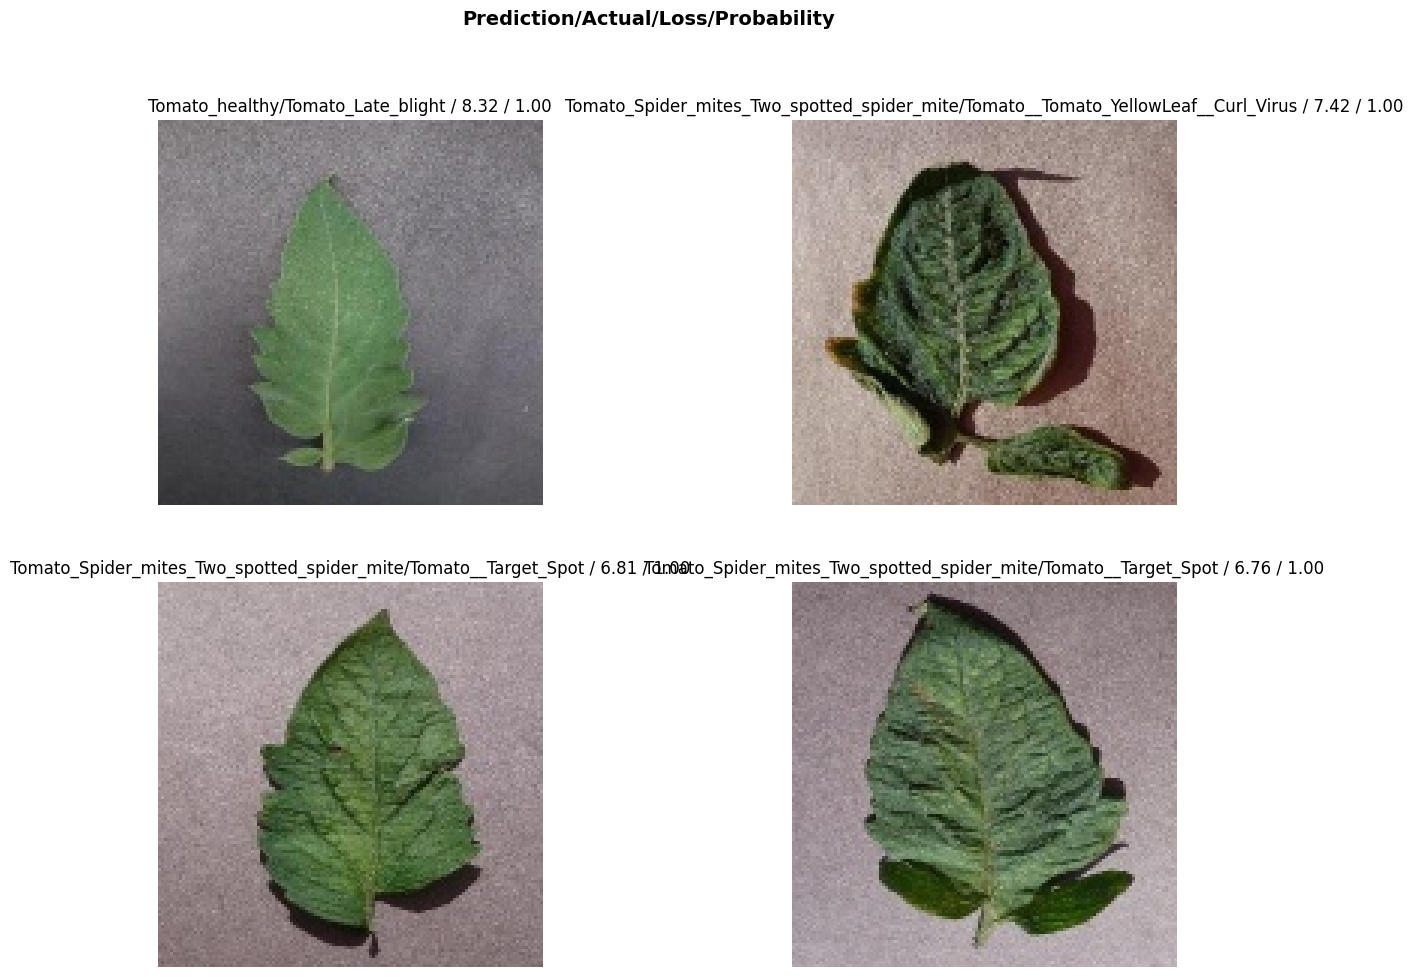

In [41]:
interpretation = ClassificationInterpretation.from_learner(learn)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(15,11))

In [42]:
interpretation.most_confused(min_val=2)

[('Tomato_Early_blight', 'Tomato_Late_blight', 14),
 ('Tomato_Early_blight', 'Tomato_Bacterial_spot', 12),
 ('Tomato__Target_Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 8),
 ('Tomato__Target_Spot', 'Tomato_healthy', 6),
 ('Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 5),
 ('Tomato_Early_blight', 'Tomato_Septoria_leaf_spot', 3),
 ('Tomato_Early_blight', 'Tomato__Target_Spot', 3),
 ('Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 3),
 ('Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 3),
 ('Tomato__Tomato_YellowLeaf__Curl_Virus',
  'Tomato_Spider_mites_Two_spotted_spider_mite',
  3),
 ('Tomato_Late_blight', 'Tomato_healthy', 2)]

In [43]:
learn.save('resnet34-classifier.pkl')

Path('models/resnet34-classifier.pkl.pth')

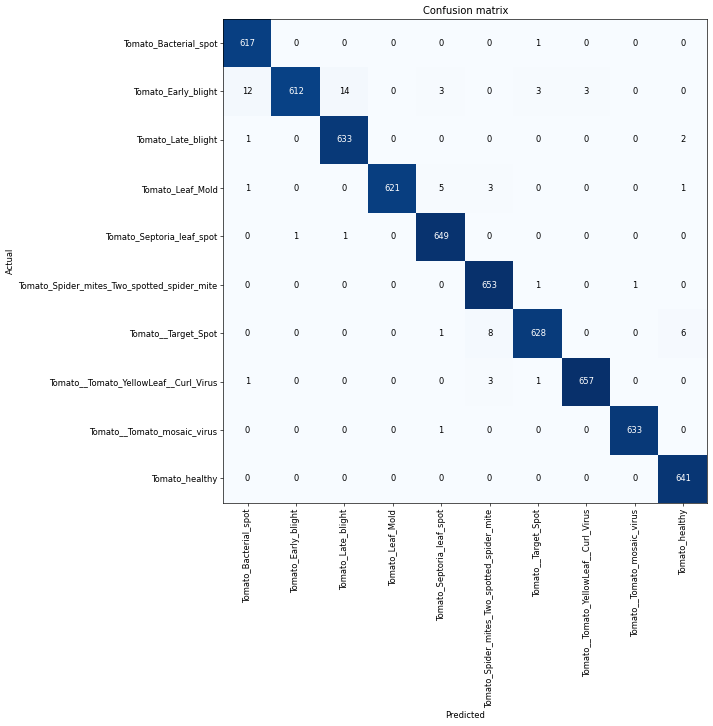

In [48]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
os.chdir("/tmp/models/")